# Purpose
* select logits' threshold for class prediction.

In [1]:
import os, sys
os.chdir("..")
sys.path.append("..")

In [2]:
from utils.support import pkl_load
from train.run import MyDataset
from train.versions.augmentation import get_augmentation
from train.versions.model import get_model

from pathlib import Path
from torch.utils.data import DataLoader
import torch
import numpy as np
from sklearn.metrics import log_loss
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
cfg = {
    
    "model_version": 4,
    "model_weights": "../output/models/hypothesis-4/fold-{fold}/model.pt",
    
    "augmentation_version": 1,
    
    "device": "cuda",
    "batch_size": 4000,
    "n_jobs": 4,
}

## Collect Predictions

In [4]:
crossval_dct = pkl_load(Path("../output/crossval_split/crossval_dct.pkl"))

folds = [1, 2, 3, 4, 5]
for fold in folds:
    df = crossval_dct[fold]["valid"]
    dataset = MyDataset(df, get_augmentation(cfg["augmentation_version"])["valid"])
    dataloader = DataLoader(dataset, batch_size=cfg["batch_size"], shuffle=False, num_workers=cfg["n_jobs"])
    
    model = get_model(cfg["model_version"], cfg["model_weights"].format(fold=fold))
    model.eval().to(cfg["device"])
    
    with torch.no_grad():    
        pred = np.array([])
        for x, y in dataloader:
            x, y = x.to(cfg["device"]), y.to(cfg["device"])
            p = model.forward(x)            
            p = torch.sigmoid(p)
            p = p.to("cpu").numpy()
            pred = np.append(pred, p)

        df["pred"] = pred

crossval_dct[1]["valid"].head(3)

,cew_img,original_img,label,pred
0,../data/dataset_B_Eye_Images/closedLeftEyes/cl...,../data/EyesDataset/003079.jpg,0,0.007419
30,../data/dataset_B_Eye_Images/openLeftEyes/Tama...,../data/EyesDataset/002960.jpg,1,0.999992
36,../data/dataset_B_Eye_Images/openRightEyes/Jos...,../data/EyesDataset/002743.jpg,1,0.999921


## Test Ths

In [5]:
ths_lst = np.linspace(0, 1, 101)[1:-1]
res = {}
for ths in ths_lst:
    res[ths] = {}
    for fold in folds:
        df = crossval_dct[fold]["valid"]
        res[ths][fold] = (df["label"] == (df["pred"] > ths)).mean()

res = pd.DataFrame(res).T
res["mean"] = res.mean(axis=1)

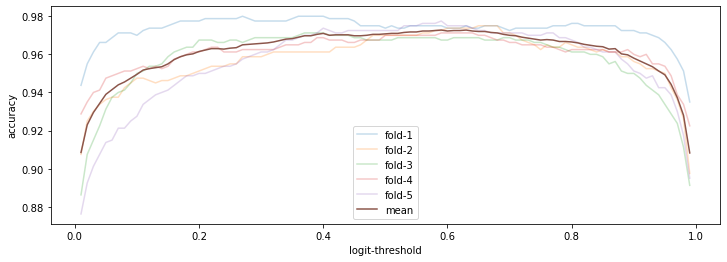

In [6]:
plt.figure(figsize=(12, 4))
for col in res.columns:
    plt.plot(res.index, res[col],
             label=col if col == "mean" else f"fold-{col}",
             alpha=1 if col == "mean" else 0.25)
plt.ylabel("accuracy")
plt.xlabel("logit-threshold")
plt.legend()
plt.savefig("../notebooks/inference_analysis/preview/accuracy_ths_selection.png", facecolor="white")
plt.show()
plt.close()

In [7]:
res[res["mean"] == res["mean"].max()]

,1,2,3,4,5,mean
0.59,0.975,0.97250,0.96750,0.97125,0.9775,0.97275
0.63,0.975,0.97375,0.96875,0.97125,0.9750,0.97275


# Test Ths - 2

In [8]:
ths_lst = np.linspace(0.3, 0.7, 1001)[1:-1]
res2 = {}
for ths in ths_lst:
    res2[ths] = {}
    for fold in folds:
        df = crossval_dct[fold]["valid"]
        res2[ths][fold] = (df["label"] == (df["pred"] > ths)).mean()
res2 = pd.DataFrame(res2).T
res2["mean"] = res2.mean(axis=1)

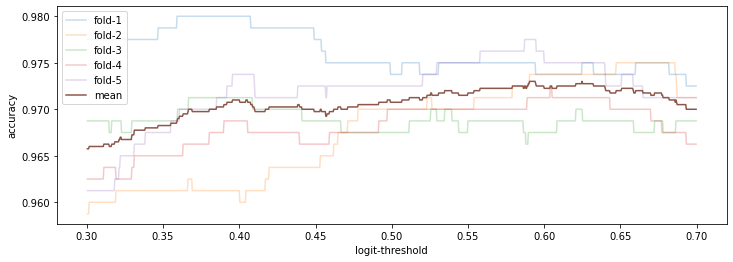

In [9]:
plt.figure(figsize=(12, 4))
for col in res2.columns:
    plt.plot(res2.index, res2[col],
             label=col if col == "mean" else f"fold-{col}",
             alpha=1 if col == "mean" else 0.25)
plt.ylabel("accuracy")
plt.xlabel("logit-threshold")
plt.legend()
plt.savefig("../notebooks/inference_analysis/preview/accuracy_ths_selection_2.png", facecolor="white")
plt.show()
plt.close()

In [10]:
res2[res2["mean"] == res2["mean"].max()]

,1,2,3,4,5,mean
0.5904,0.975,0.97375,0.9675,0.97125,0.9775,0.973
0.5908,0.975,0.97375,0.9675,0.97125,0.9775,0.973
0.5912,0.975,0.97375,0.9675,0.97125,0.9775,0.973
0.5916,0.975,0.97375,0.9675,0.97125,0.9775,0.973
0.5920,0.975,0.97375,0.9675,0.97125,0.9775,0.973
0.5924,0.975,0.97375,0.9675,0.97125,0.9775,0.973
0.5928,0.975,0.97375,0.9675,0.97125,0.9775,0.973
0.5932,0.975,0.97375,0.9675,0.97125,0.9775,0.973
0.5936,0.975,0.97375,0.9675,0.97125,0.9775,0.973
0.5940,0.975,0.97375,0.9675,0.97125,0.9775,0.973
